# In this notebook we come up with an easy way for the user to input networks to the Potapov Interpolation package, as well as a nice way to visualize the resulting system.

In [1]:
import networkx as nx
import numpy as np
from numpy import linalg as la

In [109]:
from sympy import init_printing
init_printing() 

In [110]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Passive Linear Time Delays Networks
The first component of the project takes as inputs a description of a model, which can be thought of as a graph where the nodes and edges have some special properties. These properties are outlines below.

In [333]:
G = nx.DiGraph(selfloops=True)

We use a directed graph with various properties along the nodes and edges. The direction describes the propagation of signals in the system.

There are three kinds of nodes: inputs nodes, internal nodes, and output nodes. There is the same number of input and output nodes (say n). The number of internal nodes may be different. Each internal node has an associated matrix describing its relationship between its incoming and outgoing signals. It suffices for now to take $2 \times 2$ matrices of the form $\begin{pmatrix} t && -r \\ r && t \end{pmatrix}$ corresponding to a beamsplitter, where $r$ and $t$ are the reflectivity and transmissivity of the beamsplitter, respectively. These satisfy $r^2+t^2 = 1$.

In general we may want other matrices, but it's not really necessary.

If the signal along several edges is thought of as a vector, multiplying by the matrix from the left represents the signal traveling through the element. This formalism works only for linear networks.

Let's make an example graph:

In [334]:
rs = np.asarray([0.9,0.5,0.8]) ## some sample values 
ts = np.sqrt(1.-rs**2) ## ts are determined from rs

In [335]:
N = 2 ## number of input nodes

In [405]:
for i in range(N):  ## make the input and output nodes
    G.add_node(i*2,label='x_in_'+str(i))
    G.add_node(i*2+1,label='x_out_'+str(i))
for i,(r,t) in enumerate(zip(rs,ts)): ## make the remaining nodes
    G.add_node(2*N+i,label='x_'+str(i),M=np.matrix([[t,-r],[r,t]]))

In [406]:
G.nodes(data=True) ## display the nodes

[(0, {'label': 'x_in_0'}),
 (1, {'label': 'x_out_0'}),
 (2, {'label': 'x_in_1'}),
 (3, {'label': 'x_out_1'}),
 (4, {'M': matrix([[ 0.43588989, -0.9       ],
           [ 0.9       ,  0.43588989]]), 'label': 'x_0'}),
 (5, {'M': matrix([[ 0.8660254, -0.5      ],
           [ 0.5      ,  0.8660254]]), 'label': 'x_1'}),
 (6, {'M': matrix([[ 0.6, -0.8],
           [ 0.8,  0.6]]), 'label': 'x_2'})]

Each (directed) edge $j$ has a time delay $\tau_j$. In general a delay line may have an additional phase shift $\exp(i\theta_j)$ which is determined by a number $\theta_j$.

We will also include a pair of indices for each edge. The first index corresponds to the previous node and the second index corresponds to the next node. The indices indicate enumerations of the edges with respect to the input and output nodes, respectively. If the previous or next node is an input or output node of the graph, the index will be $0$.

For now, let's assume that only internal edges have nonzero delays.

**For the visualization, it would be nice if for a given node, the incoming and outgoing edges with the same index value would appear as a straight line, since this physically means the signal is being transmitted without reflecting.**

In [407]:
## edges to inputs
G.add_edge(0,4,delay=0.,indices=(0,0),theta=0.,edge_type = 'input',edge_num=0)
G.add_edge(2,6,delay=0.,indices=(0,1),theta=0.,edge_type = 'input',edge_num=1)

## edges to outputs
G.add_edge(4,1,delay=0.,indices=(1,0),theta=0.,edge_type = 'output',edge_num=2)
G.add_edge(6,3,delay=0.,indices=(0,0),theta=0.,edge_type = 'output',edge_num=3)

## internal edges
G.add_edge(4,5,delay=1.,indices=(0,0),theta=0.,edge_type = 'internal',edge_num=4)
G.add_edge(5,4,delay=1.,indices=(1,1),theta=0.,edge_type = 'internal',edge_num=5)
G.add_edge(5,6,delay=1.,indices=(0,0),theta=0.,edge_type = 'internal',edge_num=6)
G.add_edge(6,5,delay=1.,indices=(1,1),theta=0.,edge_type = 'internal',edge_num=7)

In [408]:
G.edges(data=True)

[(0,
  4,
  {'delay': 0.0,
   'edge_num': 0,
   'edge_type': 'input',
   'indices': (0, 0),
   'theta': 0.0}),
 (2,
  6,
  {'delay': 0.0,
   'edge_num': 1,
   'edge_type': 'input',
   'indices': (0, 1),
   'theta': 0.0}),
 (4,
  1,
  {'delay': 0.0,
   'edge_num': 2,
   'edge_type': 'output',
   'indices': (1, 0),
   'theta': 0.0}),
 (4,
  5,
  {'delay': 1.0,
   'edge_num': 4,
   'edge_type': 'internal',
   'indices': (0, 0),
   'theta': 0.0}),
 (5,
  4,
  {'delay': 1.0,
   'edge_num': 5,
   'edge_type': 'internal',
   'indices': (1, 1),
   'theta': 0.0}),
 (5,
  6,
  {'delay': 1.0,
   'edge_num': 6,
   'edge_type': 'internal',
   'indices': (0, 0),
   'theta': 0.0}),
 (6,
  3,
  {'delay': 0.0,
   'edge_num': 3,
   'edge_type': 'output',
   'indices': (0, 0),
   'theta': 0.0}),
 (6,
  5,
  {'delay': 1.0,
   'edge_num': 7,
   'edge_type': 'internal',
   'indices': (1, 1),
   'theta': 0.0})]

In [409]:
## I can make a diagram for the graph, output to file
A=nx.to_agraph(G)
A.draw('file.ps',prog='neato')

# Convert the network of nodes and edges to the framework used in the paper. 

This would take the graph structure above and generate matrices $M1,M2,M2,M3$ in the notation used in `Potapov_Code.Time_Delay_Network.py`. This would allow generating an instance of Time_Delay_Network.

In [410]:
internal_edges = {(edge[0],edge[1]):edge[2] for edge in G.edges(data=True) if edge[2]['edge_type'] == 'internal'}
m = len(internal_edges)

In [411]:
# input_edges = [edge for edge in G.edges(data=True) if edge[2]['edge_type'] == 'input']
# output_edges = [edge for edge in G.edges(data=True) if edge[2]['edge_type'] == 'output']

In [440]:
M1 = np.zeros((m,m))
internal_node_range = range(2*N,num_nodes)
internal_connections = []
for i in internal_node_range: ## internal nodes
    outgoing_connections = nx.edges(G,[i])
    internal_connections += [connection for connection in outgoing_connections if connection[1] in internal_node_range]

for i in internal_connections:
    for j in internal_connections:
        if i[1] == j[0]:
            matrix_indices = G.edge[i[0]][i[1]]['indices'][0], G.edge[j[0]][j[1]]['indices'][1]
            M1[internal_edges[j]['edge_num']-2*N,internal_edges[i]['edge_num']-2*N] = G.node[i[1]]['M'][matrix_indices]

In [441]:
M1

array([[ 0.       ,  0.9      ,  0.       ,  0.       ],
       [-0.5      ,  0.       ,  0.       ,  0.8660254],
       [ 0.8660254,  0.       ,  0.       ,  0.5      ],
       [ 0.       ,  0.       , -0.8      ,  0.       ]])

In [429]:
all_connections = []
for i in range(num_nodes): ## internal nodes
    outgoing_connections = nx.edges(G,[i])
    all_connections += [connection for connection in outgoing_connections if connection[1] in range(num_nodes)]

In [456]:
all_edges = {(edge[0],edge[1]):edge[2] for edge in G.edges(data=True)}
m_all = len(all_edges)

In [457]:
U = np.zeros((m_all,m_all))

for i in all_connections:
    for j in all_connections:
        if i[1] == j[0]:
            matrix_indices = G.edge[i[0]][i[1]]['indices'][0], G.edge[j[0]][j[1]]['indices'][1]
            U[all_edges[j]['edge_num'],all_edges[i]['edge_num']] = G.node[i[1]]['M'][matrix_indices]

In [463]:
U[3]

array([ 0. ,  0.6,  0. ,  0. ,  0. ,  0. ,  0.6,  0. ])

In [447]:
## should coincide with M1

U[4:8,4:8]

array([[ 0.       ,  0.9      ,  0.       ,  0.       ],
       [-0.5      ,  0.       ,  0.       ,  0.8660254],
       [ 0.8660254,  0.       ,  0.       ,  0.5      ],
       [ 0.       ,  0.       , -0.8      ,  0.       ]])

# Usage Description

Using the run_Potapov function of this method generates the variables that will be used for the first part of the visualization. Those are contained in an instance of the Time_Delay_Network. Specifically, the outputs we will want to plot are (1) `Time_Delay_Network.roots` (2) `Time_Delay_Network.spatial_modes`. 

The roots $r_1,...,r_n$ are a list of complex numbers corresponding to the modes indexed by $1,...,n$. The imaginary part of root $r_k$ correspond to the frequency of mode $k$, and the real part of $r_k$ indicate the decay coefficients of mode $k$.

The spatial_modes are a list $v_1,...,v_n$ of complex-valued vectors. Each vector $v_k$ in the list corresponds to a mode $k$, in the same order as the roots. Each vector has the same length as the number of time delays of the network, $\tau_1,...,\tau_m$. The $l_{th}$ component $v_{k,l}$ of vector $v_k$ indicates the spatially normalized amplitude of mode $k$ along the delay $\tau_l$. 

What would be cool is to be able to select one or many modes $1,...,k,...,n$ and to illustrate the spatial component of the signal of the selected modes along the graph. Specifically, the frequency of the root could correspond to a color or a periodic sinusoidal shape (higher frequency would be more blue or a shorter period), or both. The absolute value of the spatial mode component could be indicated by the thickness of the signal along each time delay. A phase shift could be indicated by a shift in the frequency of a sinusoidal signal.

In [11]:
import Potapov_Code

In [225]:
Network = Potapov_Code.Time_Delay_Network.Example3() ## an example network with hardcoded values

In [227]:
Network.run_Potapov(commensurate_roots=True) ## run the analysis

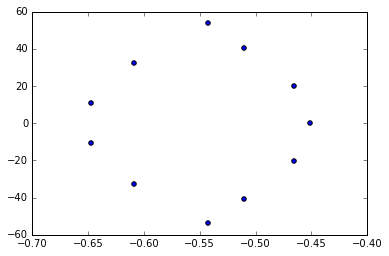

In [238]:
roots = Network.roots  ## roots
plt.scatter(map(lambda z: z.real, roots), map(lambda z: z.imag, roots))

In [237]:
Network.spatial_modes ## the spatial modes

[matrix([[-1.48727953 +4.66694763e-16j],
         [ 1.48974810 +0.00000000e+00j],
         [ 0.90468607 -3.51626818e-16j],
         [-1.04741674 -3.02032128e-16j]]), matrix([[ 0.59123272+0.86497598j],
         [ 0.94661031+0.33190779j],
         [ 0.40453718+1.3928748j ],
         [ 1.62411460+0.j        ]]), matrix([[ 0.59123272-0.86497598j],
         [ 0.94661031-0.33190779j],
         [ 0.40453718-1.3928748j ],
         [ 1.62411460+0.j        ]]), matrix([[ 1.46055765+0.j        ],
         [ 0.10451599+1.45435338j],
         [-0.77553231-0.556405j  ],
         [-0.67586950-0.87084148j]]), matrix([[ 1.46055765+0.j        ],
         [ 0.10451599-1.45435338j],
         [-0.77553231+0.556405j  ],
         [-0.67586950+0.87084148j]]), matrix([[-1.12842454+0.22723406j],
         [ 0.59750551+0.93771369j],
         [-0.99353600-0.92653161j],
         [ 1.53122646+0.j        ]]), matrix([[-1.12842454-0.22723406j],
         [ 0.59750551-0.93771369j],
         [-0.99353600+0.92653161j],
  